In [1]:
#라이브러리 호출
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 8)
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import scipy.stats
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels
import scipy as sp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets, linear_model

In [2]:
#데이터 전처리 및 파생변수 만들기
#기초 통계량 작성
df = pd.read_csv("c:/Users\jeho.choi\Downloads/Regular_Season_Batter.csv")
df=df.dropna()
df['starting_salary_2'] = df['starting_salary'].str.slice(start=0, stop=-2)
df['height']=df['height/weight'].str.slice(start=0,stop=3)
df['weight']=df['height/weight'].str.slice(start=6,stop=8)
df['year_born_2']=df['year_born'].str.slice(start=0,stop=4)
df[['starting_salary_2','height','weight','year_born_2']]=df[['starting_salary_2','height','weight','year_born_2']].apply(pd.to_numeric)
df['old']=df['year']-df['year_born_2']
df = pd.concat([df,pd.get_dummies(df['team'], drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['position'], drop_first=True)], axis=1)
df=df.drop(['batter_name','team','height/weight','year_born','position','career','starting_salary'],axis='columns')
df.describe()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,...,히어로즈,내야수(우투우타),내야수(우투좌타),내야수(좌투좌타),외야수(우투양타),외야수(우투우타),외야수(우투좌타),외야수(좌투좌타),포수(우투우타),포수(우투좌타)
count,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,...,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000
mean,171.493818,2012.812364,0.243833,77.748364,225.231273,34.209455,63.549818,11.253091,1.059636,6.550545,...,0.005091,0.407273,0.082909,0.026182,0.001455,0.139636,0.110545,0.118545,0.098909,0.010182
std,95.821954,4.394782,0.100731,45.480861,174.563332,29.731130,54.291147,10.340700,1.693190,8.493864,...,0.071195,0.491505,0.275845,0.159734,0.038125,0.346735,0.313683,0.323370,0.298649,0.100427
min,1.000000,1999.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,95.000000,2010.000000,0.213500,32.000000,46.000000,6.000000,10.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,174.000000,2014.000000,0.262000,88.000000,212.000000,28.000000,55.000000,9.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,256.000000,2016.000000,0.297500,119.000000,388.000000,57.000000,112.000000,19.000000,2.000000,10.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,344.000000,2018.000000,1.000000,144.000000,600.000000,129.000000,195.000000,47.000000,13.000000,53.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
#종속변수와 설명변수 간 상관관계 분석
correlations = df.corr()['OPS'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(21))
print('\nMost Negative Correlations:\n', correlations.head(20))

Most Positive Correlations:
 SB     0.196404
CS     0.230763
3B     0.246190
E      0.247890
old    0.296650
HBP    0.417323
GDP    0.450559
SO     0.497668
HR     0.515852
G      0.519994
BB     0.529875
AB     0.531502
2B     0.535613
R      0.543882
H      0.554119
RBI    0.562708
TB     0.574368
avg    0.916835
OBP    0.938592
SLG    0.973600
OPS    1.000000
Name: OPS, dtype: float64

Most Negative Correlations:
 year_born_2   -0.212811
weight        -0.128544
해태            -0.092932
쌍방울           -0.065689
우리            -0.060029
포수(우투우타)      -0.056465
LG            -0.055109
히어로즈          -0.049971
KT            -0.044850
내야수(우투좌타)     -0.041923
포수(우투좌타)      -0.027828
NC            -0.025828
롯데            -0.025642
batter_id     -0.015338
외야수(좌투좌타)     -0.013322
외야수(우투우타)     -0.000462
넥센             0.006774
한화             0.007083
삼성             0.018880
외야수(우투좌타)      0.026869
Name: OPS, dtype: float64


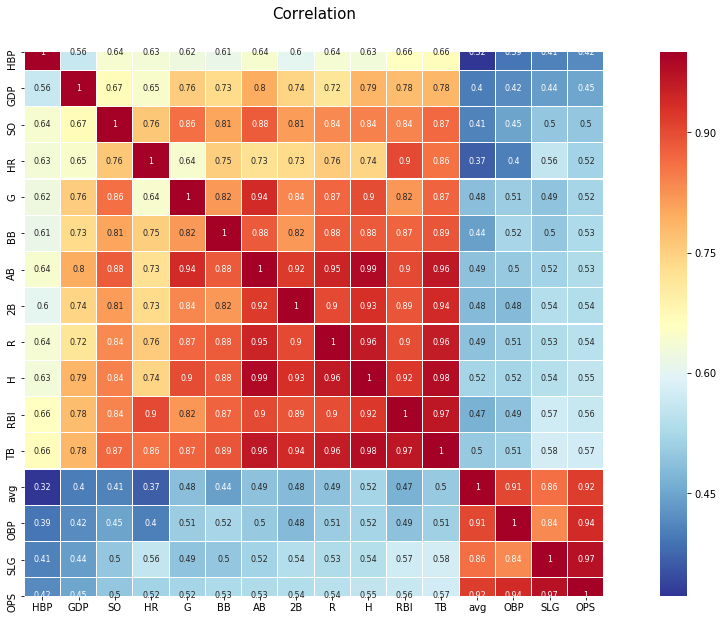

In [4]:
#상관계수 높은 설명변수 선정 및 상관관계 시각화

df=df[['HBP','GDP','SO','HR','G','BB','AB','2B','R','H','RBI','TB','avg','OBP','SLG','OPS']]

colormap = plt.cm.RdYlBu_r 
plt.figure(figsize=(20, 10)) 
plt.title("Correlation", y = 1.05, size = 15) 
sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 8})

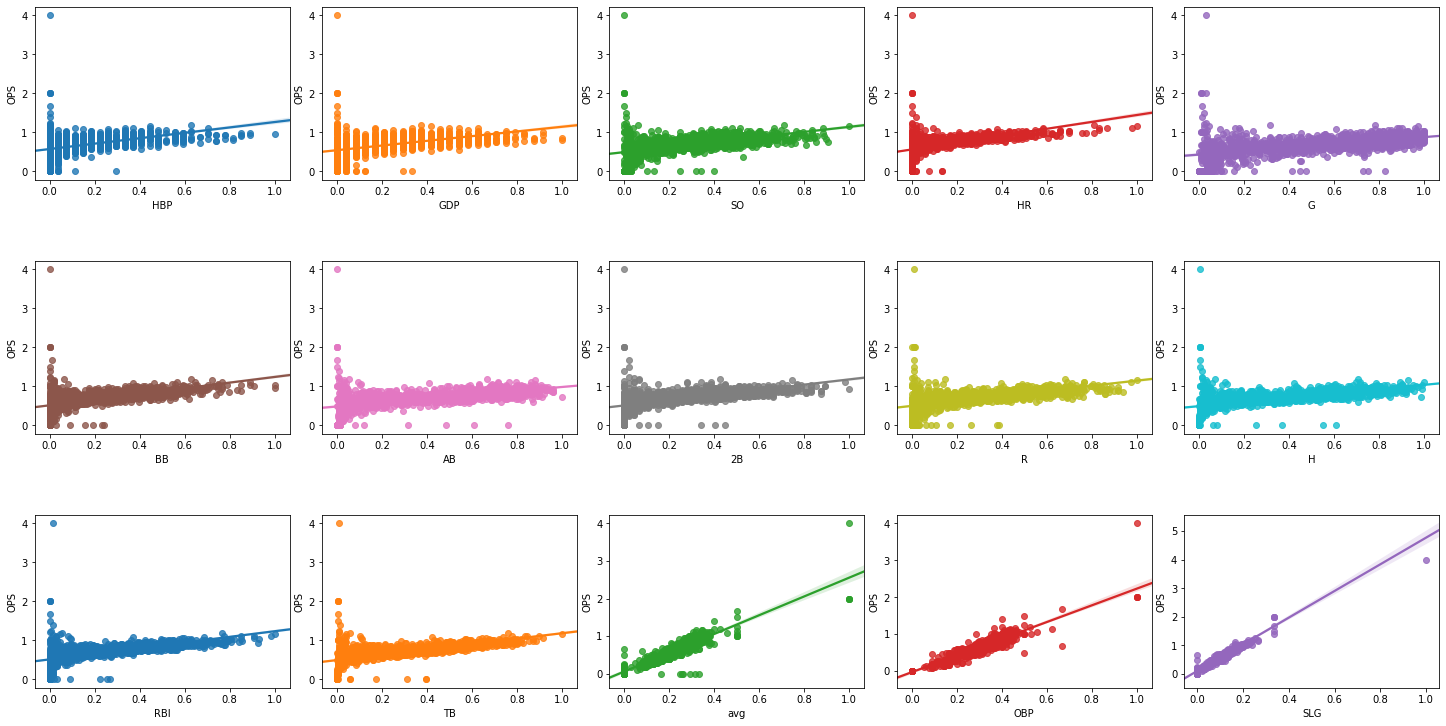

In [5]:
#설명변수 스케일링 및 종속변수와 선형관계 검토

min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['HBP','GDP','SO','HR','G','BB','AB','2B','R','H','RBI','TB','avg','OBP','SLG']
x = df.loc[:,column_sels]
y = df['OPS']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()

for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [6]:
#변수별 회귀계수 및 P-value 도출

dfX0 = df.loc[:,column_sels]
dfX = sm.add_constant(dfX0)
dfy = df['OPS']

model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.948e+28
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:34:12   Log-Likelihood:                 42634.
No. Observations:                1375   AIC:                        -8.524e+04
Df Residuals:                    1359   BIC:                        -8.515e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.857e-17   7.26e-16      0.067      0.9

C:\Users\jeho.choi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
#다중 공선성을 피하기 위한 변수별 VIF 점검

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,10.460494,const
1,2.024352,HBP
2,3.565129,GDP
3,7.854001,SO
4,101.610802,HR
5,10.819485,G
6,6.724006,BB
7,95.999466,AB
8,24.261027,2B
9,20.238395,R


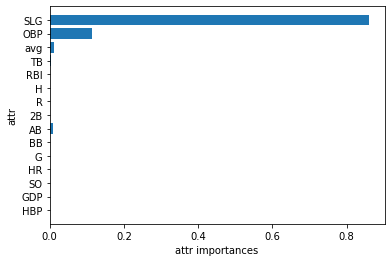

In [8]:
#RandomForest를 활용한 변수 중요도 점검 : 반영은 X

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=0)

forest = RandomForestRegressor(n_estimators=100,random_state=0)
forest.fit(X_train,y_train)

def plot_feature_importances(model):

    n_features = x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), x.columns.values)
    plt.xlabel("attr importances")
    plt.ylabel("attr")
    plt.ylim(-1, n_features)

plt.show()

plot_feature_importances(forest)

In [9]:
#VIF 높은 설명변수 제거 후 OLS Regression 재실시

column_sels = ['HBP','GDP','SO','G','BB','avg','OBP','SLG']
dfX0 = df.loc[:,column_sels]
dfX = sm.add_constant(dfX0)
dfy = df['OPS']

model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.187e+29
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:34:13   Log-Likelihood:                 42319.
No. Observations:                1375   AIC:                        -8.462e+04
Df Residuals:                    1366   BIC:                        -8.457e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.249e-16   8.88e-16     -0.141      0.8

C:\Users\jeho.choi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [10]:
#P-Value가 높은 avg 변수 제거 후 최종 변수 선택

column_sels = ['HBP','GDP','SO','G','BB','OBP','SLG']
dfX0 = df.loc[:,column_sels]
dfX = sm.add_constant(dfX0)
dfy = df['OPS']

x = df.loc[:,column_sels]

model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.931e+29
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:34:13   Log-Likelihood:                 43050.
No. Observations:                1375   AIC:                        -8.608e+04
Df Residuals:                    1367   BIC:                        -8.604e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -6.8e-16    5.2e-16     -1.307      0.1

C:\Users\jeho.choi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jeho.choi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jeho.choi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jeho.choi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jeho.choi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0

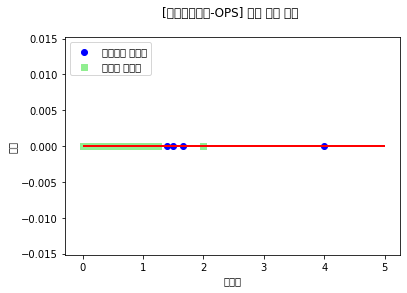

In [11]:
#잔차들의 등분산성 검정

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

plt.scatter(y_train_pred, y_train_pred-y_train, c='blue',marker='o',label='트레이닝 데이터')
plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen',marker='s',label='테스트 데이터')

plt.xlabel('예측값')
plt.ylabel('잔차')
plt.hlines(y=0,xmin=0,xmax=5,lw=2,color='red')
plt.title('[다중설명변수-OPS] 잔차 분석 그림 \n')
plt.legend(loc=2)
plt.show()

0.9717731173123564

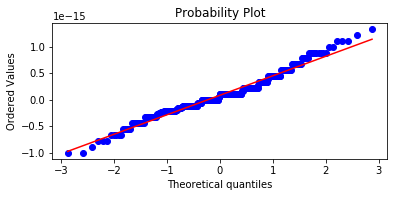

In [12]:
#잔차들의 정규성 검정

residual = y_test_pred-y_test

fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

r**2

In [13]:
# 예측 모델링, Kfold 교차 검증법으로 MSE Score 도출


kf = KFold(n_splits=10)

#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)

l_regression = linear_model.LinearRegression()
scores = cross_val_score(l_regression, x, y, cv=kf, scoring=None)
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores

l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, x, y, cv=kf, scoring=None)
scores_map['Ridge'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

model = make_pipeline(PolynomialFeatures(degree=3), linear_model.Ridge())
scores = cross_val_score(model, x, y, cv=kf, scoring=None)
scores_map['PolyRidge'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

MSE: 1.00000 (+/- 0.00000)
MSE: 0.99917 (+/- 0.00023)
MSE: 0.98464 (+/- 0.03431)


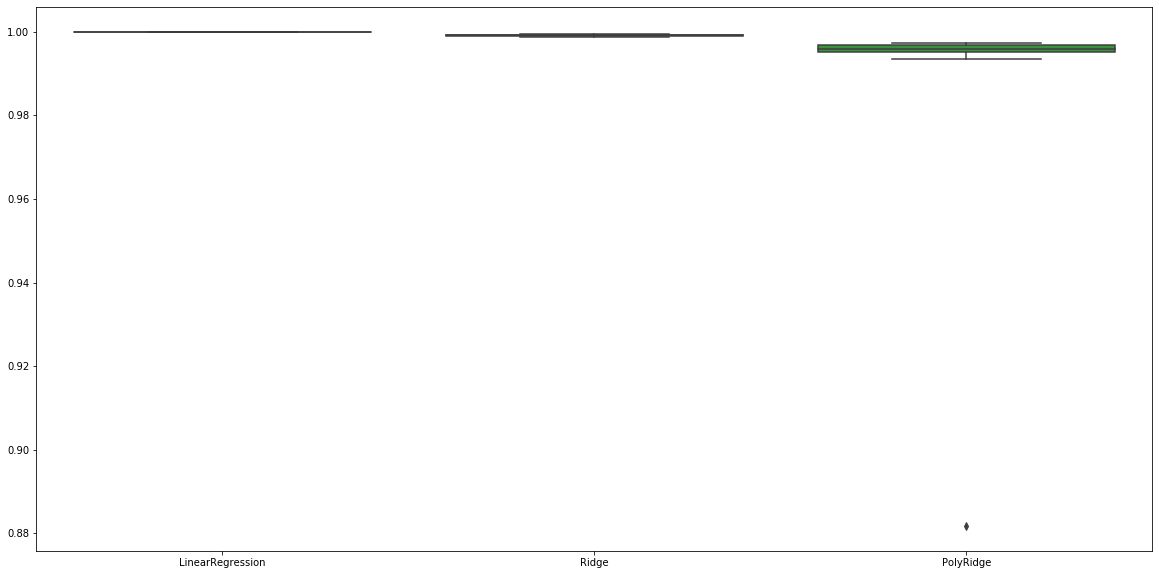

In [14]:
# 평가지표 시각화 및 예측 모델 최종 선정 : PolyRidge 모델 선택

plt.figure(figsize=(20, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)